In [1]:
%cd /content/drive/MyDrive/Colab\ Notebooks/입찰/LSTM

/content/drive/MyDrive/Colab Notebooks/입찰/LSTM


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.optimizers import Adam, RMSprop

In [3]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test

sc1 = MinMaxScaler(feature_range=(0,1))
scaled_train = sc1.fit_transform(train_raw) # scaled train
scaled_test = sc1.fit_transform(test_raw) # scaled test

In [4]:
def datamake(data):
  ndata = []
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    temp = sum / 2
    #temp += np.random.rand(1) / 100
    ndata.append(temp)
  ndata = np.array(ndata) # train_added
  return ndata

In [5]:
train_added_scaled = datamake(scaled_train)
test_added_scaled = datamake(scaled_test)

In [6]:
print(train_added_scaled.shape)
print(test_added_scaled.shape)

(4884, 1)
(542, 1)


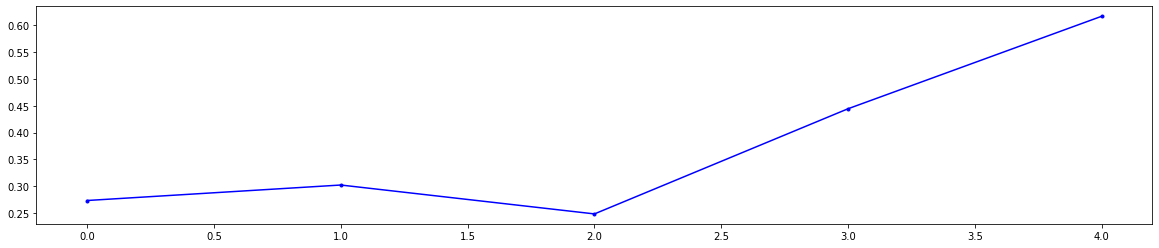

In [7]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(scaled_train[-5:], '.-',color = 'blue', label = 'GroundTruth')

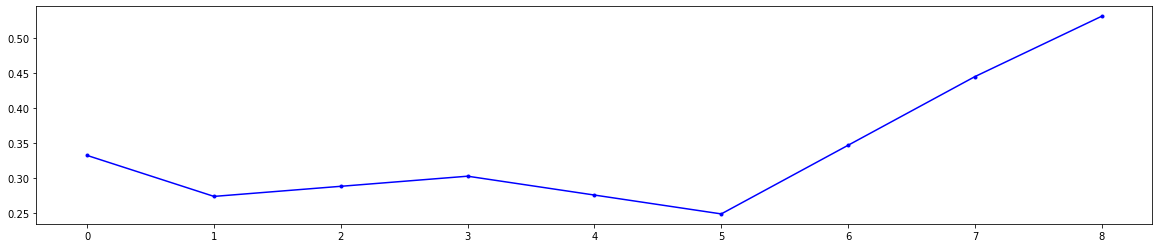

In [8]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(train_added_scaled[-9:], '.-',color = 'blue', label = 'GroundTruth')

In [9]:
seq_length = 3

In [10]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]+1, 2):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [12]:
X_train, Y_train = make_data(train_added_scaled) # train_added_scaled
X_test, Y_test = make_data(test_added_scaled) # test_added_scaled

In [13]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

concat = concatenate([x, y])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
output = Dense(1)(output)
model = Model(inputs = inputs, outputs = output)

#model.summary()

In [14]:
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mse')
model.fit(X_train, Y_train, epochs = 100, batch_size = 10, validation_split=0.1)

Epoch 1/100
220/220 [==============================] - 15s 15ms/step - loss: 0.0221 - val_loss: 0.0139
Epoch 2/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 3/100
220/220 [==============================] - 2s 8ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 4/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0106 - val_loss: 0.0080
Epoch 5/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 6/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 7/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0101 - val_loss: 0.0141
Epoch 8/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 9/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 10/100
220/220 [==============================] - 2s 9ms/step - loss: 0.0092 - val_

In [15]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)
train = sc1.inverse_transform(train_added_scaled)
mean_train_error = np.average(np.abs(train[seq_length::2] - predicted_X_train))

print("평균 training error:", mean_train_error)

평균 training error: 0.16490633590025267


In [16]:
predicted_X_test = model.predict(X_test)
predicted_X_test = sc1.inverse_transform(predicted_X_test)
test = sc1.inverse_transform(test_added_scaled)
mean_train_error = np.average(np.abs(test[seq_length::2] - predicted_X_test))

print("평균 test error:", mean_train_error)

평균 test error: 0.19669197522563514


In [17]:
print(predicted_X_test.shape)
print(test.shape)

(270, 1)
(542, 1)


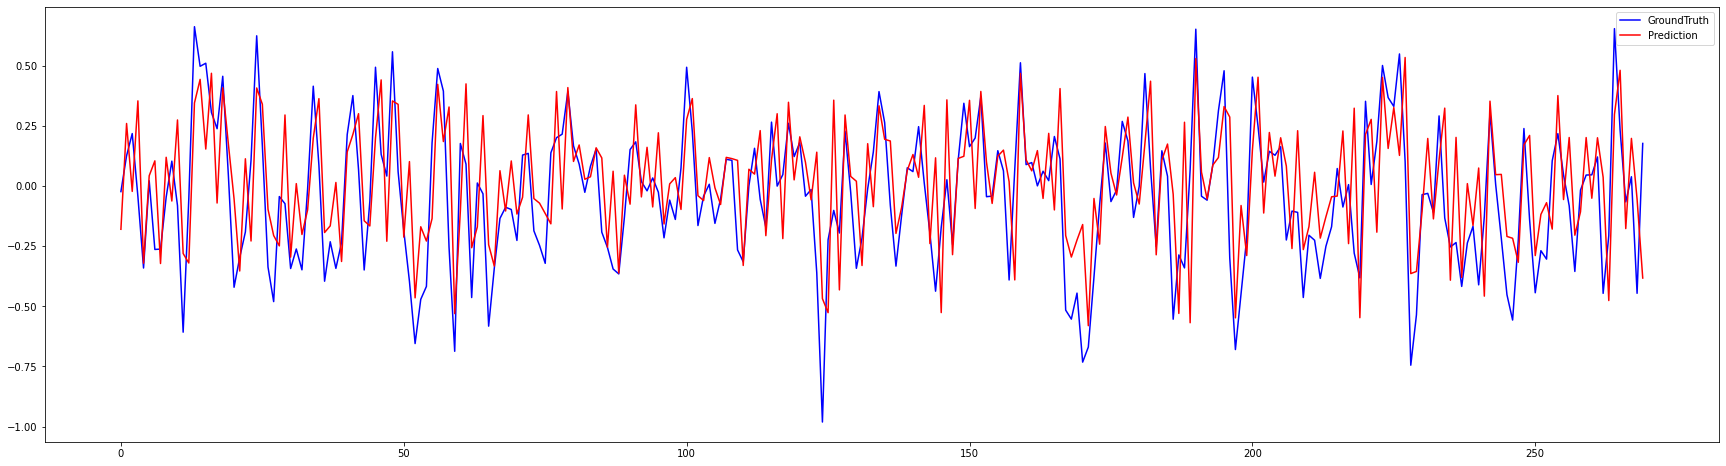

In [18]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test[seq_length::2], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_test, color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM_')